In [1]:
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from math import sqrt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor as DTRegressor
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.ensemble import AdaBoostRegressor as Ada


%config InlineBackend.figure_format = 'retina'

from math import sqrt

from pandas.tseries.offsets import DateOffset
import datetime
import time

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import datetime
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)
%matplotlib inline


Lets Download read in the data set, then subset it keeping only the variables needed


lets get the dataset AND SUBSET ON LTHE LAST 12 MONTHS

In [2]:
data= pd.read_csv('C:\\Users\\lydia\\OneDrive\\Msc Data Science\\CETM46 product development\\assigment 2 part2\\windapp\\T1.csv')



                           Data Cleaning

In [3]:
data.columns = ['Date','Power','Wind_speed','Theoretical_power','Wind_direction']

In [4]:
data.dtypes
data


,Date,Power,Wind_speed,Theoretical_power,Wind_direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


find missing values

In [5]:
data.isnull().sum()

Date                 0
Power                0
Wind_speed           0
Theoretical_power    0
Wind_direction       0
dtype: int64

I will delete NA as its a negligeable amount compared to our 200 thousand dataframe

In [6]:
data =data.dropna()
data.shape[0]

50530

lets also remove the idle shut downs because  
In our case, it is not correct to include samples referred to operating conditions far 
from the normal working range of a wind turbine.

Power Output (kW). It must be above 0 kW and below the maximum rated power (2050kW). Check on manufacturer specifics

Wind Speed (m/s).  we are going to evaluate turbine performance. so we need to exclude all those points that don't bring actual power output.

Pitch angle (°). Pitch angle is an indicator of the position of turbine blades with respect to wind direction. In normal operating condition, this angle is very low and slightly negative (from -5° to - 0°). Values far from these limits refer to particular conditions that must be excluded from future analysis.

In [7]:
data = data[data.Power>0]

In [8]:
data['Wind_direction'].min()

0.0

In [9]:
df_clean = data[data['Wind_speed']>3]
df_clean = data[data['Wind_speed'] < 25]

df_clean.shape[0]

39691

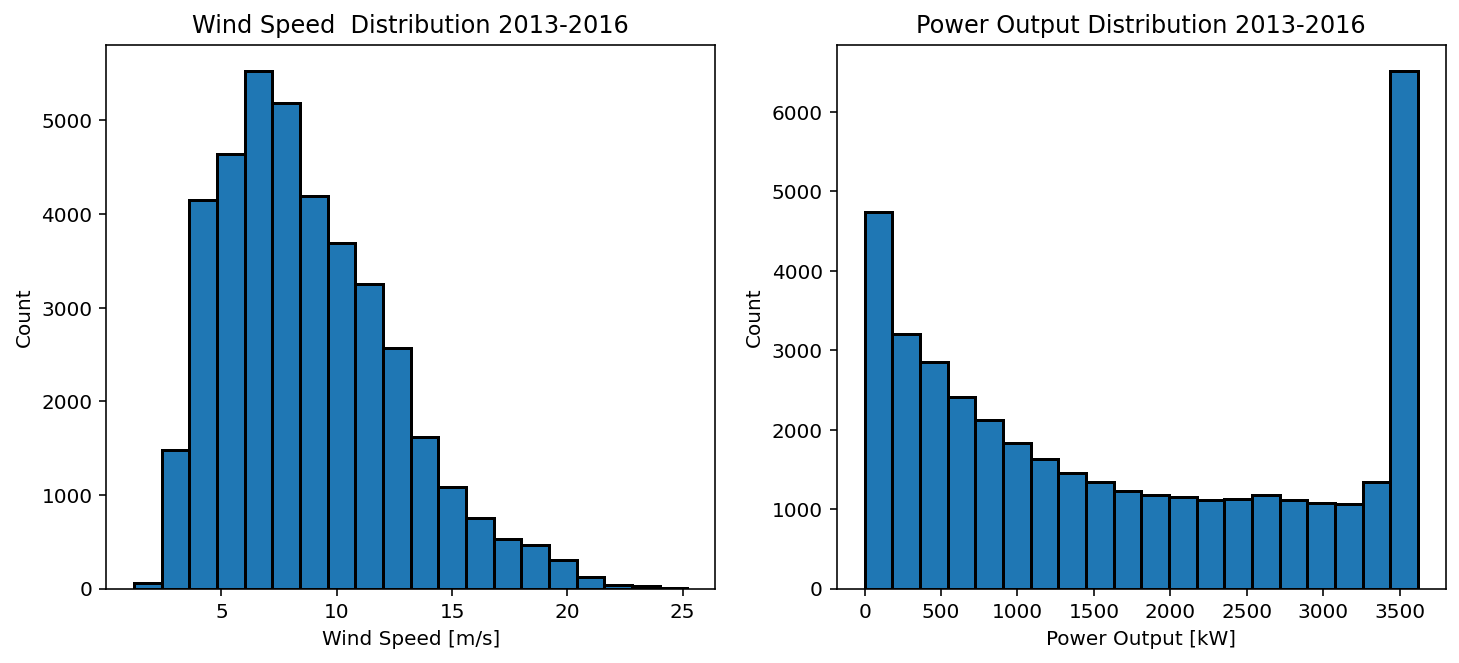

In [10]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(data['Wind_speed'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('Wind Speed  Distribution 2013-2016')
ax1.set_xlabel('Wind Speed [m/s]')
ax1.set_ylabel('Count')
ax2.hist(data['Power'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Power Output Distribution 2013-2016')
ax2.set_xlabel('Power Output [kW]')
ax2.set_ylabel('Count')

plt.show()

lets see what we have now

lets create features to help us visualise our data better 

                                    convert from degree to radians
                                    


In [11]:
df_clean['Date'] = pd.to_datetime(data['Date'])
df_clean.sort_values(by=['Date'], inplace=True, ascending=True)

df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Day'] =  df_clean['Date'].dt.day
df_clean['Hour'] =  df_clean['Date'].dt.hour
df_clean= df_clean.set_index('Date')

C:\Users\lydia\AppData\Local\Temp/ipykernel_18092/1214543563.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lydia\AppData\Local\Temp/ipykernel_18092/1214543563.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lydia\AppData\Local\Temp/ipykernel_18092/1214543563.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [12]:
df_model =pd.DataFrame()

this time lets use the ten minute interval values

In [13]:
X = df_clean[['Wind_direction', 'Wind_speed']]
y = df_clean['Power']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
#lets scale the data
# Make pipeline
pipe = make_pipeline(StandardScaler(), SVR())

In [23]:
# 5-fold CV
r2_cv = cross_val_score(pipe, X_train, y_train, cv=5)
print(r2_cv)
print(np.mean(r2_cv))

[0.94013998 0.93776277 0.94084671 0.93740891 0.94269248]
0.9397701684118974


In [24]:
# Fit SVM model
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

# Train R2
print(f'Train R2: {pipe.score(X_train, y_train)}')

# Test R2, MSE, MAE
print(f'Test R2: {pipe.score(X_test, y_test)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred)}')


Train R2: 0.9446067504742626
Test R2: 0.9448151683328981
Test MAE: 159.09064714410317
Test MSE: 88593.69056773803


lets save our pipe


In [25]:
from pickle import dump
from pickle import load as ld
#Pipe_svr =dump(pipe, open('pipe.pkl', 'wb'))


Piper = ld(open('pipe.pkl', 'rb'))

Text(0, 0.5, 'Predicted Active Power')

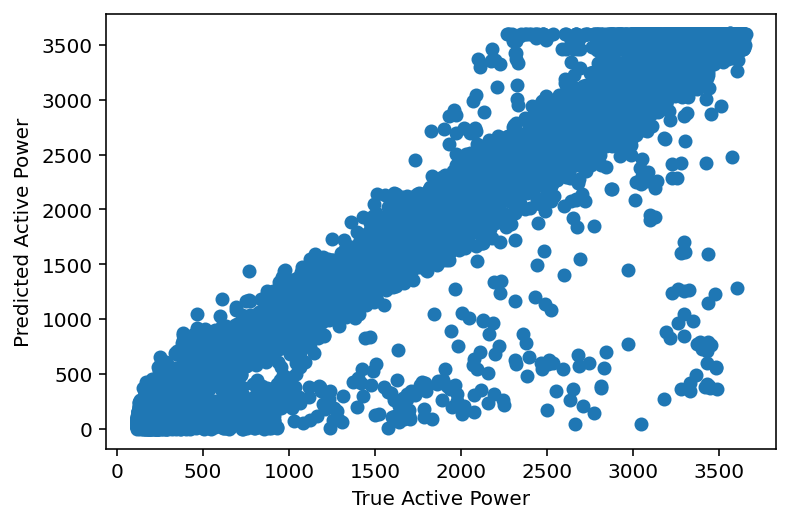

In [26]:
plt.scatter(y_pred, y_test)
plt.xlabel('True Active Power')
plt.ylabel('Predicted Active Power')

In [27]:
# Entire data
Piper.predict(X_test.tail(1))

array([470.37572989])

In [28]:
# Predicted power into dataframe
y_pred = pd.DataFrame(y_pred_all, columns=['active_power'])
y_pred.index = y.index

y_pred

NameError: name 'y_pred_all' is not defined

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

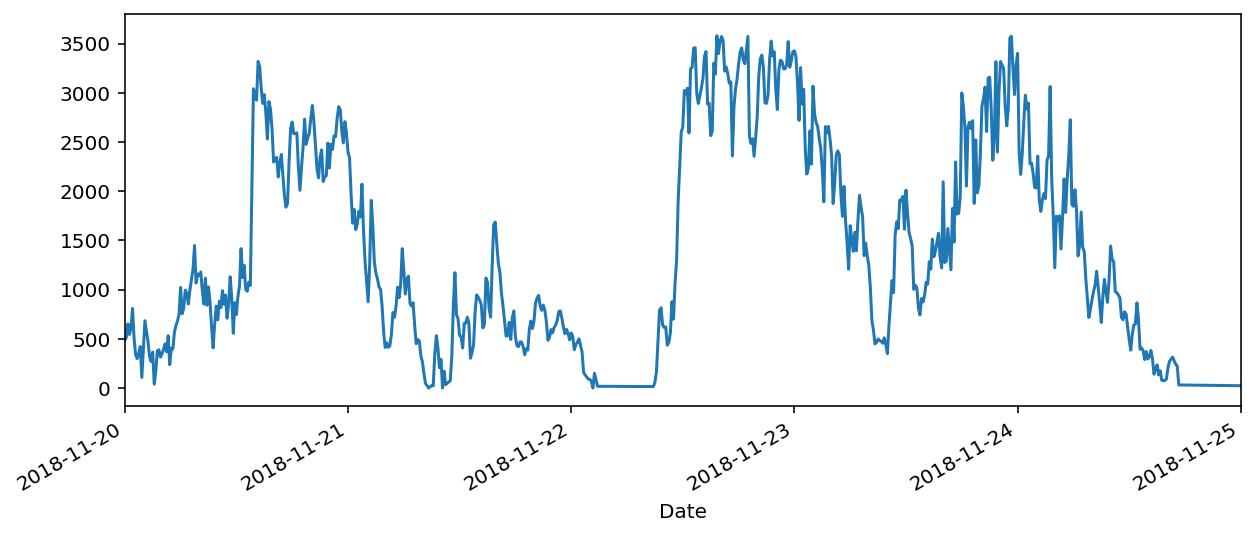

In [29]:
# True power (blue) vs. predicted power (orange)
t = df_clean.index
ax = y.plot(figsize=(10,4), xlim=(np.datetime64('2018-11-20'), np.datetime64('2018-11-25')))
y_pred.plot(figsize=(10,4), xlim=(np.datetime64('2018-11-20'), np.datetime64('2018-11-25')), ax=ax)
plt.title('Predicted vs. True Wind Turbine Power', size=15)
plt.ylabel('Active Power [kW]')

Let's visualize the non-linear function (our SVM hyperplane) of Active Power as a function of Wind Speed and Wind Direction,  
P
=
f
(
w
s
,
w
d
)

In [34]:
ws = np.linspace(0, 26, 50)
wd = np.linspace(0, 360, 50)
ws, wd = np.meshgrid(ws, wd)

# Prediction space dataframe
X_space = pd.DataFrame({'Wind_direction': wd.flatten(), 'Wind_speed': ws.flatten()})

y_pred_space = Piper.predict(X_space)

In [38]:
df_clean.reset_index()

,Date,Power,Wind_speed,Theoretical_power,Wind_direction,Year,Month,Day,Hour
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018,1,1,0
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0
...,...,...,...,...,...,...,...,...,...
39686,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23
39687,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23
39688,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23
39689,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23


In [35]:
X_space

,Wind_direction,Wind_speed
0,0.0,0.000000
1,0.0,0.530612
2,0.0,1.061224
3,0.0,1.591837
4,0.0,2.122449
...,...,...
2495,360.0,23.877551
2496,360.0,24.408163
2497,360.0,24.938776
2498,360.0,25.469388


In [31]:
pipe.steps[1][1].get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [32]:
pipe.steps[1][1]._gamma

0.5

Text(0.5, 0.92, 'SVM (C=1, Gamma=0.5)')

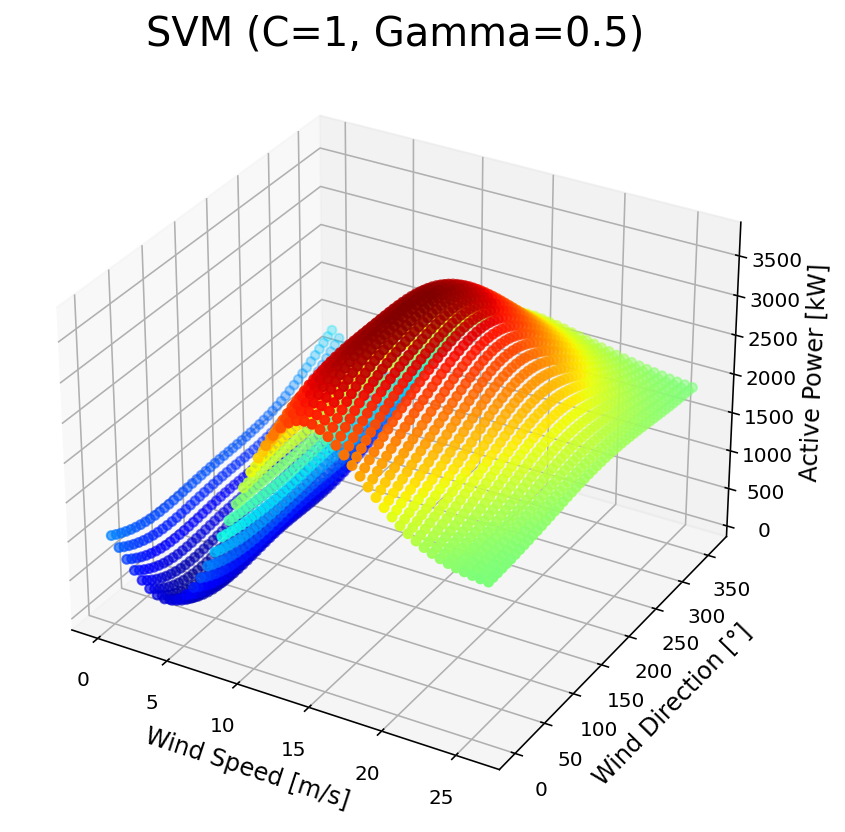

In [33]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X_space.wind_speed.values, X_space.wind_dir.values, y_pred_space, 
             c=y_pred_space, cmap='jet')

# ax.scatter3D(X.wind_speed.values, X.wind_dir.values, y, 
#              c='b', alpha=0.2)

ax.set_xlabel('Wind Speed [m/s]', size=12)
ax.set_ylabel('Wind Direction [°]', size=12)
ax.set_zlabel('Active Power [kW]', size=12)
ax.set_title('SVM (C=1, Gamma=0.5)', size=20)